/Users/badrirohith/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Fetching data from USGS API ...
 API request successful
API data saved at Day01_DataCollection_API/api_data.csv

📊 API Dataset Summary:
                                time   magnitude   longitude    latitude  \
count                            492  492.000000  492.000000  492.000000   
mean   2023-08-15 07:29:14.622050560    4.800772   24.556356   -0.017742   
min       2023-08-01 02:20:46.066000    4.500000 -179.931400  -62.177500   
25%    2023-08-07 00:07:31.091749888    4.500000  -75.063325  -21.994050   
50%    2023-08-15 00:00:27.827500032    4.700000   70.097650   -1.305250   
75%    2023-08-22 19:23:30.149750016    4.900000  129.117575   21.743200   
max       2023-08-31 21:43:25.888000    7.100000  179.899300   83.475200   
std                              NaN    0.375329  119.982102   29.960864   

            depth  
count  492.000000  
mean    73.788683  
min      2.963000  
25%     10.000000  
50%     25.064500  
75%     71.293500  
max    646.537000  
std    125.042290  

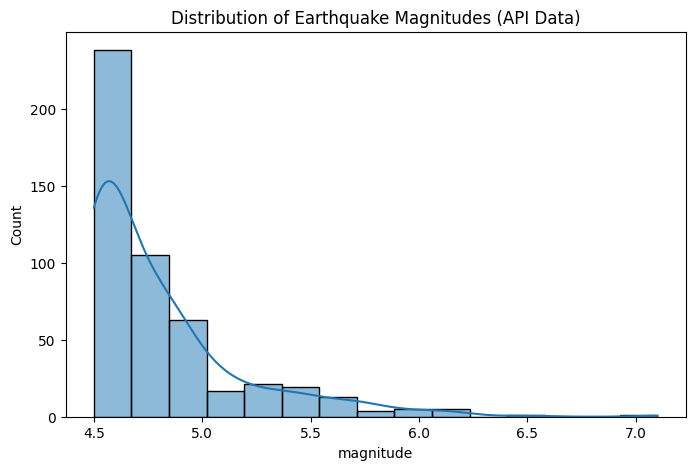

📊 Saved: api_magnitude_hist.png


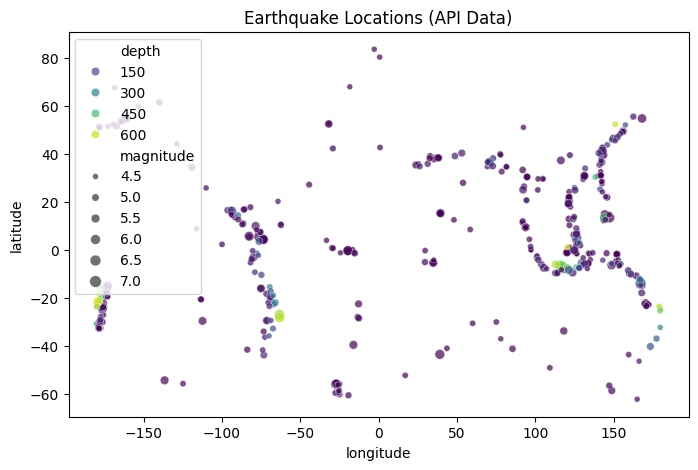

📊 Saved: api_locations.png
✅ Historical dataset saved at Day01_DataCollection_API/historical_clean.csv

📊 Historical Dataset Summary:
                                Date    Latitude   Longitude       Depth  \
count                            492  492.000000  492.000000  492.000000   
mean   2023-08-15 07:29:14.622050560   -0.017742   24.556356   73.788683   
min       2023-08-01 02:20:46.066000  -62.177500 -179.931400    2.963000   
25%    2023-08-07 00:07:31.091749888  -21.994050  -75.063325   10.000000   
50%    2023-08-15 00:00:27.827500032   -1.305250   70.097650   25.064500   
75%    2023-08-22 19:23:30.149750016   21.743200  129.117575   71.293500   
max       2023-08-31 21:43:25.888000   83.475200  179.899300  646.537000   
std                              NaN   29.960864  119.982102  125.042290   

        Magnitude  
count  492.000000  
mean     4.800772  
min      4.500000  
25%      4.500000  
50%      4.700000  
75%      4.900000  
max      7.100000  
std      0.375329  
M

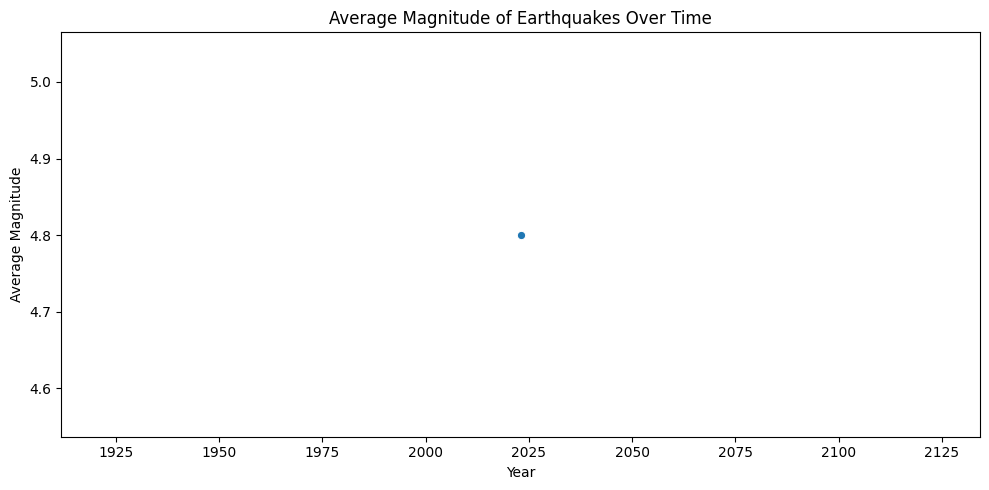

📊 Saved: historical_yearly_trend.png


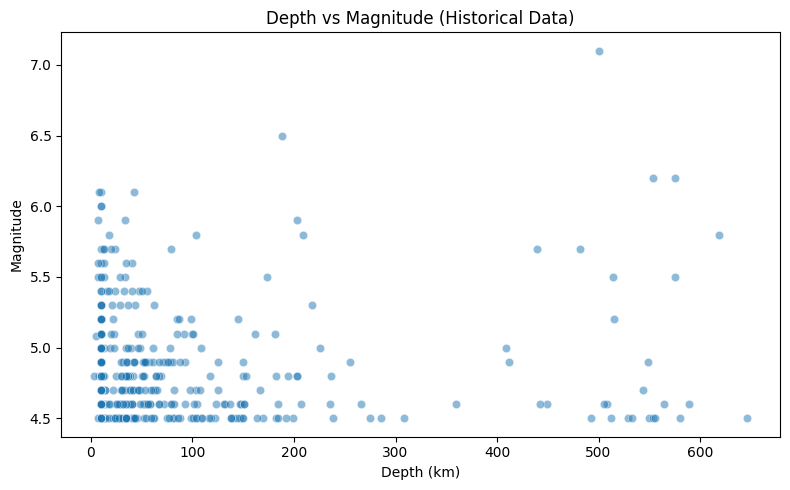

📊 Saved: depth_vs_magnitude.png


In [2]:
#Day 01 - Data Collection (USGS API + EDA)


import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure plots show inline
%matplotlib inline  

# -----------------------------
# Setup folders
# -----------------------------
os.makedirs("Day01_DataCollection_API/api_visualizations", exist_ok=True)
os.makedirs("Day01_DataCollection_API/hist_visualizations", exist_ok=True)

# -----------------------------
# 1. Fetch Earthquake Data from USGS API
# -----------------------------
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2023-08-01",
    "endtime": "2023-09-01",
    "minmagnitude": 4.5
}

print("Fetching data from USGS API ...")
response = requests.get(url, params=params)
if response.status_code != 200:
    print("API request failed:", response.status_code)
else:
    print(" API request successful")

data = response.json()

records = []
for feat in data['features']:
    props = feat['properties']
    geom = feat['geometry']
    records.append({
        "time": pd.to_datetime(props['time'], unit='ms'),
        "place": props['place'],
        "magnitude": props['mag'],
        "longitude": geom['coordinates'][0],
        "latitude": geom['coordinates'][1],
        "depth": geom['coordinates'][2]
    })

df_api = pd.DataFrame(records)

# Save API dataset
df_api.to_csv("Day01_DataCollection_API/api_data.csv", index=False)
print("API data saved at Day01_DataCollection_API/api_data.csv")

# -----------------------------
# 2. Exploratory Data Analysis (EDA) - API Data
# -----------------------------
print("\n📊 API Dataset Summary:")
print(df_api.describe())
print("\n📊 Info:")
print(df_api.info())

# Histogram of magnitudes
plt.figure(figsize=(8,5))
sns.histplot(df_api['magnitude'], bins=15, kde=True)
plt.title("Distribution of Earthquake Magnitudes (API Data)")
plt.savefig("Day01_DataCollection_API/api_visualizations/api_magnitude_hist.png")
plt.show()
print("📊 Saved: api_magnitude_hist.png")

# Scatterplot of locations
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_api, x="longitude", y="latitude",
    size="magnitude", hue="depth", alpha=0.7, palette="viridis"
)
plt.title("Earthquake Locations (API Data)")
plt.savefig("Day01_DataCollection_API/api_visualizations/api_locations.png")
plt.show()
print("📊 Saved: api_locations.png")

# -----------------------------
# 3. Historical Dataset Processing
# -----------------------------
df_hist = df_api.copy()  # Using API data as historical for now

# Select & clean
df_hist = df_hist[['time', 'latitude', 'longitude', 'depth', 'magnitude', 'place']]
df_hist['time'] = pd.to_datetime(df_hist['time'], errors='coerce')
df_hist = df_hist.dropna()

# Rename columns consistently
df_hist = df_hist.rename(columns={
    'time': 'Date',
    'latitude': 'Latitude',
    'longitude': 'Longitude',
    'depth': 'Depth',
    'magnitude': 'Magnitude',
    'place': 'Location'
})

# Save cleaned historical dataset
df_hist.to_csv("Day01_DataCollection_API/historical_clean.csv", index=False)
print("✅ Historical dataset saved at Day01_DataCollection_API/historical_clean.csv")

# -----------------------------
# 4. Historical EDA & Visualizations
# -----------------------------
print("\n📊 Historical Dataset Summary:")
print(df_hist.describe())
print("Missing values:\n", df_hist.isnull().sum())

# Time series trend - average magnitude per year
df_hist['Year'] = df_hist['Date'].dt.year
plt.figure(figsize=(10,5))
sns.lineplot(
    data=df_hist.groupby('Year')['Magnitude'].mean().reset_index(),
    x='Year', y='Magnitude', marker="o"
)
plt.title("Average Magnitude of Earthquakes Over Time")
plt.ylabel("Average Magnitude")
plt.xlabel("Year")
plt.tight_layout()
plt.savefig("Day01_DataCollection_API/hist_visualizations/historical_yearly_trend.png")
plt.show()
print("📊 Saved: historical_yearly_trend.png")

# Magnitude vs Depth scatterplot
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_hist, x="Depth", y="Magnitude", alpha=0.5)
plt.title("Depth vs Magnitude (Historical Data)")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.savefig("Day01_DataCollection_API/hist_visualizations/depth_vs_magnitude.png")
plt.show()
print("📊 Saved: depth_vs_magnitude.png")


In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from shapely.geometry import Point

In [4]:
# Load Earthquake CSV
hist_path = "../Day01_DataCollection_API/historical_clean.csv"

try:
    df_hist = pd.read_csv(hist_path)
    print(f"✅ Earthquake data loaded successfully from {hist_path}")
except FileNotFoundError:
    print(f"❌ File not found: {hist_path}")
    raise

# Rename columns if necessary
df_hist = df_hist.rename(columns={
    'latitude': 'Latitude',
    'longitude': 'Longitude',
    'mag': 'Magnitude',
    'place': 'Location',
    'depth': 'Depth',
    'time': 'Date'
})

# Convert time column to datetime
df_hist['Date'] = pd.to_datetime(df_hist['Date'], errors='coerce')

print("📊 Earthquake Data Sample:")
display(df_hist.head())

✅ Earthquake data loaded successfully from ../Day01_DataCollection_API/historical_clean.csv
📊 Earthquake Data Sample:


,Date,Location,magnitude,Longitude,Latitude,Depth
0,2023-08-31 21:43:25.888,South Sandwich Islands region,4.5,-26.6644,-55.9173,35.000
1,2023-08-31 19:33:42.976,"51 km SSE of Honiara, Solomon Islands",5.1,160.2109,-9.8238,22.741
2,2023-08-31 19:18:37.570,"117 km WSW of Pangai, Tonga",4.8,-175.4463,-20.0729,149.933
3,2023-08-31 18:45:19.038,"78 km W of Murghob, Tajikistan",4.8,73.0729,38.0851,50.206
4,2023-08-31 16:53:12.225,"23 km SSW of Tagāb, Afghanistan",4.6,69.5179,34.6691,14.895


In [8]:
def load_soil_data(shapefile_path):
    """Load soil data with error handling"""
    try:
        soil_data = gpd.read_file(shapefile_path)
        if soil_data.crs is None:
            soil_data = soil_data.set_crs("EPSG:4326")
            print("⚠️ CRS missing. Setting CRS to EPSG:4326 (WGS84)")
        return soil_data
    except Exception as e:
        print(f"❌ Error loading shapefile: {e}")
        return None

soil_path = "./DSMW.shp"  # adjust path if needed
soil_data = load_soil_data(soil_path)

if soil_data is not None:
    print(f"✅ Soil data loaded successfully! Columns: {soil_data.columns.tolist()}")
else:
    raise SystemExit("Soil data could not be loaded.")

⚠️ CRS missing. Setting CRS to EPSG:4326 (WGS84)
✅ Soil data loaded successfully! Columns: ['SNUM', 'FAOSOIL', 'DOMSOI', 'PHASE1', 'PHASE2', 'MISCLU1', 'MISCLU2', 'PERMAFROST', 'CNTCODE', 'CNTNAME', 'SQKM', 'COUNTRY', 'geometry']


In [9]:
possible_soil_cols = ['SU_SYM90', 'DOMSOI', 'SU_SYM85', 'SOIL', 'CODE']
available_soil_cols = [col for col in possible_soil_cols if col in soil_data.columns]

if not available_soil_cols:
    raise SystemExit("❌ No valid soil classification columns found.")

soil_col = available_soil_cols[0]
print(f"🌍 Using soil column: {soil_col}")

🌍 Using soil column: DOMSOI


In [10]:
eq_points = gpd.GeoDataFrame(
    df_hist,
    geometry=gpd.points_from_xy(df_hist.Longitude, df_hist.Latitude),
    crs="EPSG:4326"
)

soil_data = soil_data.to_crs(eq_points.crs)

print("✅ Converted Earthquake DataFrame to GeoDataFrame")
display(eq_points.head())

✅ Converted Earthquake DataFrame to GeoDataFrame


,Date,Location,magnitude,Longitude,Latitude,Depth,geometry
0,2023-08-31 21:43:25.888,South Sandwich Islands region,4.5,-26.6644,-55.9173,35.000,POINT (-26.6644 -55.9173)
1,2023-08-31 19:33:42.976,"51 km SSE of Honiara, Solomon Islands",5.1,160.2109,-9.8238,22.741,POINT (160.2109 -9.8238)
2,2023-08-31 19:18:37.570,"117 km WSW of Pangai, Tonga",4.8,-175.4463,-20.0729,149.933,POINT (-175.4463 -20.0729)
3,2023-08-31 18:45:19.038,"78 km W of Murghob, Tajikistan",4.8,73.0729,38.0851,50.206,POINT (73.0729 38.0851)
4,2023-08-31 16:53:12.225,"23 km SSW of Tagāb, Afghanistan",4.6,69.5179,34.6691,14.895,POINT (69.5179 34.6691)


In [11]:
# ✅ Cell 6: Merge Earthquake Data with Soil Data and Display
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# -----------------------------
# 1. Load the saved historical dataset (from Day01)
# -----------------------------
eq_df = pd.read_csv("Day01_DataCollection_API/historical_clean.csv")
print("✅ Historical earthquake data loaded:", eq_df.shape)

# -----------------------------
# 2. Convert to GeoDataFrame
# -----------------------------
geometry = [Point(xy) for xy in zip(eq_df['Longitude'], eq_df['Latitude'])]
eq_gdf = gpd.GeoDataFrame(eq_df, geometry=geometry, crs="EPSG:4326")

print("✅ Converted to GeoDataFrame with CRS:", eq_gdf.crs)

# -----------------------------
# 3. Spatial Join: Merge with soil data
# -----------------------------
# Make sure soil_data is already loaded as a GeoDataFrame
eq_with_soil = gpd.sjoin(eq_gdf, soil_data, how="left", predicate="within")

# Pick soil column (we already know DOMSOI works from Cell 3)
soil_col = "DOMSOI"

# -----------------------------
# 4. Stats
# -----------------------------
print(f"🌍 Earthquakes with soil data: {len(eq_with_soil)}")
print(f"🚫 Earthquakes without soil data (NaN): {eq_with_soil[soil_col].isna().sum()}")

# ✅ Safely display relevant columns
expected_cols = ['Date', 'Magnitude', 'Depth', 'Location', 'Latitude', 'Longitude', soil_col]
available_cols = [col for col in expected_cols if col in eq_with_soil.columns]

print(f"📊 Showing first rows with available columns: {available_cols}")
display(eq_with_soil[available_cols].head())

✅ Historical earthquake data loaded: (492, 6)
✅ Converted to GeoDataFrame with CRS: EPSG:4326
🌍 Earthquakes with soil data: 492
🚫 Earthquakes without soil data (NaN): 369
📊 Showing first rows with available columns: ['Date', 'Magnitude', 'Depth', 'Location', 'Latitude', 'Longitude', 'DOMSOI']


,Date,Magnitude,Depth,Location,Latitude,Longitude,DOMSOI
0,2023-08-31 21:43:25.888,4.5,35.000,South Sandwich Islands region,-55.9173,-26.6644,NaN
1,2023-08-31 19:33:42.976,5.1,22.741,"51 km SSE of Honiara, Solomon Islands",-9.8238,160.2109,NaN
2,2023-08-31 19:18:37.570,4.8,149.933,"117 km WSW of Pangai, Tonga",-20.0729,-175.4463,NaN
3,2023-08-31 18:45:19.038,4.8,50.206,"78 km W of Murghob, Tajikistan",38.0851,73.0729,I
4,2023-08-31 16:53:12.225,4.6,14.895,"23 km SSW of Tagāb, Afghanistan",34.6691,69.5179,I


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: better plots in Jupyter
%matplotlib inline
sns.set(style="whitegrid")

In [19]:
hist_path = "Day01_DataCollection_API/historical_clean.csv"

try:
    df_hist = pd.read_csv(hist_path)
    print("Historical dataset loaded successfully!")
    print("Columns:", df_hist.columns.tolist())
except FileNotFoundError:
    print(f"File not found: {hist_path}")

Historical dataset loaded successfully!
Columns: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Location']


In [18]:
print(os.path.exists("Day01_DataCollection_API/historical_clean.csv"))


True


In [21]:
import geopandas as gpd

soil_path = "DSMW.shp"

try:
    eq_with_soil = gpd.read_file(soil_path)
    print("Soil shapefile loaded successfully!")
    print("Columns:", eq_with_soil.columns.tolist())
except Exception as e:
    print(f"Error loading soil data: {e}")
    eq_with_soil = pd.DataFrame()

Soil shapefile loaded successfully!
Columns: ['SNUM', 'FAOSOIL', 'DOMSOI', 'PHASE1', 'PHASE2', 'MISCLU1', 'MISCLU2', 'PERMAFROST', 'CNTCODE', 'CNTNAME', 'SQKM', 'COUNTRY', 'geometry']


In [22]:
df_hist = df_hist.rename(columns={
    "time": "Date",
    "latitude": "Latitude",
    "longitude": "Longitude",
    "depth": "Depth",
    "magnitude": "Magnitude",
    "place": "Location"
})

df_hist['Date'] = pd.to_datetime(df_hist['Date'], errors='coerce')
df_hist = df_hist.dropna(subset=['Date'])

print("Columns after renaming:", df_hist.columns.tolist())
print("Historical dataset shape:", df_hist.shape)

Columns after renaming: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Location']
Historical dataset shape: (492, 6)


In [23]:
# --- Cell 5: Spatial Join for Earthquake + Soil Data ---

import geopandas as gpd

# Convert earthquake dataframe into GeoDataFrame
gdf_eq = gpd.GeoDataFrame(
    df_hist,
    geometry=gpd.points_from_xy(df_hist['Longitude'], df_hist['Latitude']),
    crs="EPSG:4326"
)

# If soil shapefile has no CRS, set it
if eq_with_soil.crs is None:
    eq_with_soil = eq_with_soil.set_crs("EPSG:4326")  # adjust if you know the true CRS

# Reproject soil to match earthquake CRS
eq_with_soil = eq_with_soil.to_crs("EPSG:4326")

# Spatial join: assign soil type to each earthquake point
df_all_geo = gpd.sjoin(
    gdf_eq,
    eq_with_soil[['DOMSOI', 'geometry']],
    how="left",
    predicate="within"
)

print("Unified dataset shape:", df_all_geo.shape)
print("Soil data coverage:", df_all_geo['DOMSOI'].notna().sum())

Unified dataset shape: (492, 9)
Soil data coverage: 123


In [24]:
for col in ['Magnitude', 'Depth']:
    if col in df_all_geo.columns:
        df_all_geo[col] = df_all_geo[col].fillna(df_all_geo[col].median())

for col in ['Location', 'DOMSOI']:
    if col in df_all_geo.columns and not df_all_geo[col].empty:
        df_all_geo[col] = df_all_geo[col].fillna(df_all_geo[col].mode()[0])

print("Missing values after imputation:")
print(df_all_geo.isnull().sum())

Missing values after imputation:
Date             0
Latitude         0
Longitude        0
Depth            0
Magnitude        0
Location         0
geometry         0
index_right    369
DOMSOI           0
dtype: int64


In [25]:
print("\n=== BASIC STATISTICS ===")
print(df_all_geo[['Magnitude', 'Depth']].describe())

print("\nSoil type counts:")
if 'DOMSOI' in df_all_geo.columns:
    print(df_all_geo['DOMSOI'].value_counts().head(10))


=== BASIC STATISTICS ===
        Magnitude       Depth
count  492.000000  492.000000
mean     4.800772   73.788683
std      0.375329  125.042290
min      4.500000    2.963000
25%      4.500000   10.000000
50%      4.700000   25.064500
75%      4.900000   71.293500
max      7.100000  646.537000

Soil type counts:
DOMSOI
I     410
Bd     11
Af      7
Ao      7
Nd      6
WR      5
Bh      4
Xk      4
Ah      3
Ws      2
Name: count, dtype: int64


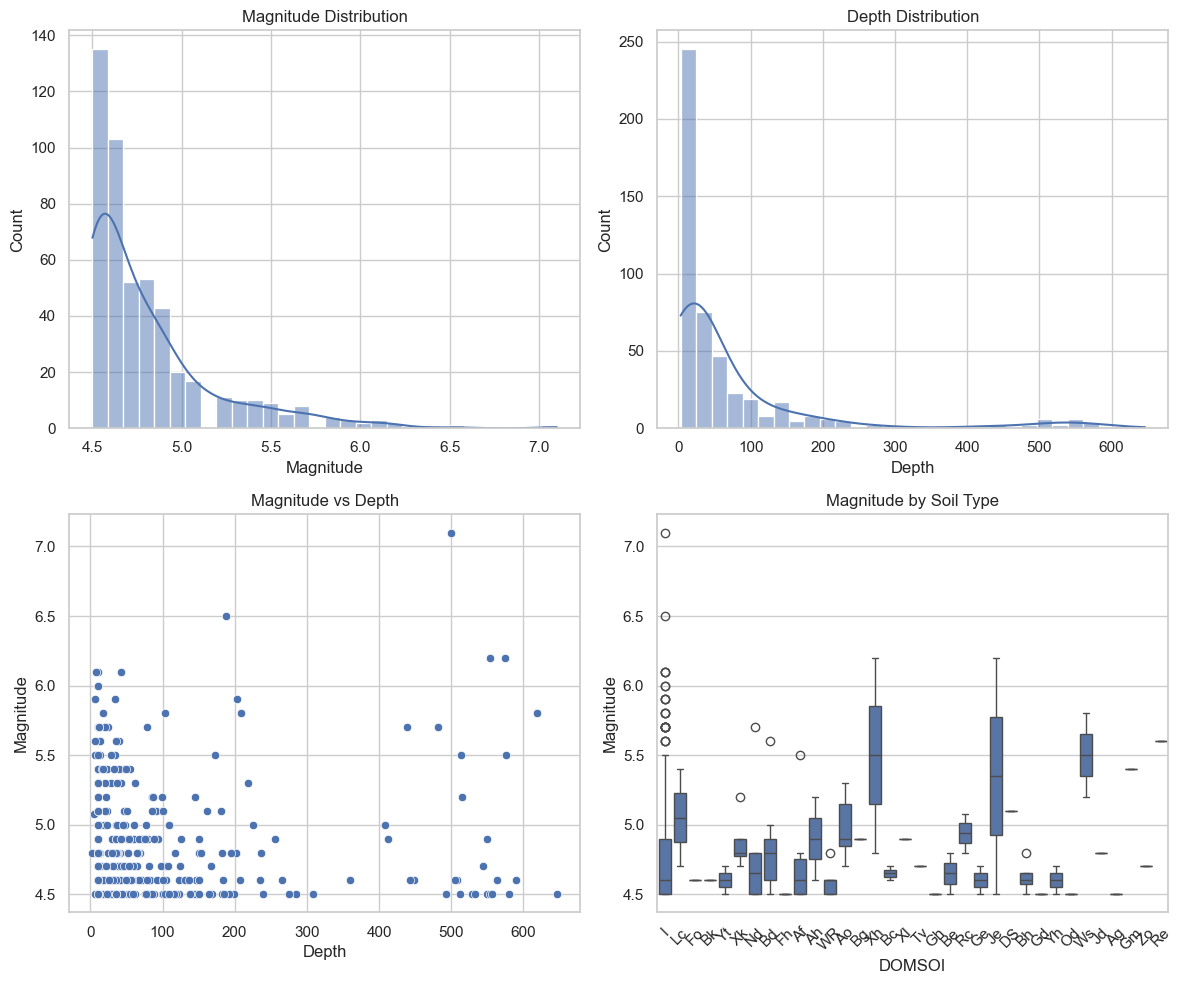

In [26]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
sns.histplot(df_all_geo['Magnitude'], bins=30, kde=True)
plt.title("Magnitude Distribution")

plt.subplot(2,2,2)
sns.histplot(df_all_geo['Depth'], bins=30, kde=True)
plt.title("Depth Distribution")

plt.subplot(2,2,3)
sns.scatterplot(df_all_geo, x='Depth', y='Magnitude')
plt.title("Magnitude vs Depth")

if df_all_geo['DOMSOI'].notna().sum() > 0:
    plt.subplot(2,2,4)
    sns.boxplot(data=df_all_geo, x='DOMSOI', y='Magnitude')
    plt.xticks(rotation=45)
    plt.title("Magnitude by Soil Type")

plt.tight_layout()
plt.show()

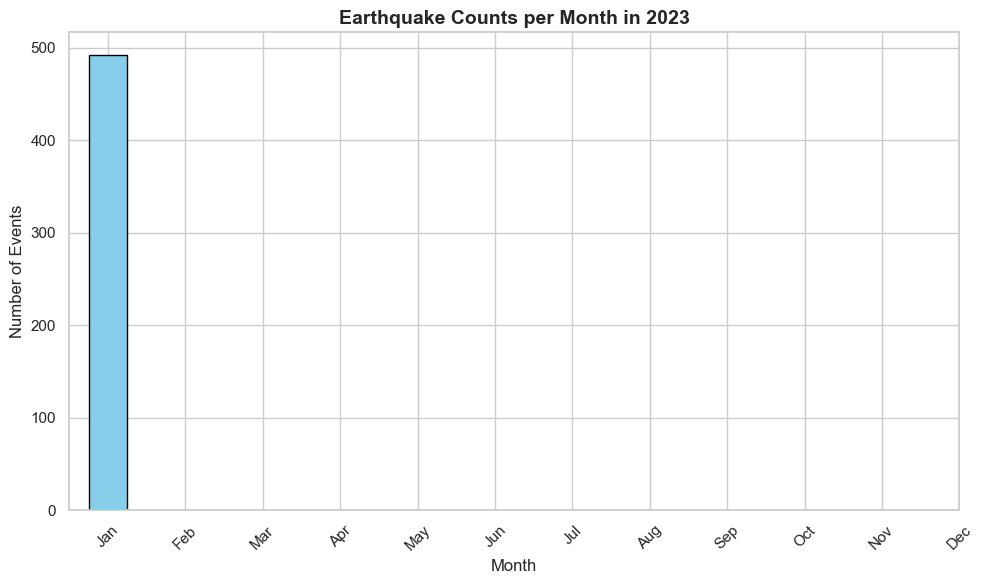

In [27]:
# Cell 9: Earthquake Counts per Month (for 2023)

import matplotlib.pyplot as plt

# Ensure Date column is in datetime format
df_hist['Date'] = pd.to_datetime(df_hist['Date'], errors='coerce')

# Filter only 2023 data
df_2023 = df_hist[df_hist['Date'].dt.year == 2023]

# Group by month
monthly_counts = df_2023.groupby(df_2023['Date'].dt.month).size()

# Plot
plt.figure(figsize=(10,6))
monthly_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Earthquake Counts per Month in 2023", fontsize=14, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.xticks(range(0,12), 
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
           rotation=45)

plt.tight_layout()
plt.show()

In [28]:
save_path = "earthquake_cleaned_day3.csv"

df_all_geo.to_csv(save_path, index=False)
print(f"Cleaned dataset saved to: {save_path}")

Cleaned dataset saved to: earthquake_cleaned_day3.csv


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate synthetic dataset
np.random.seed(42)
n = 300

df = pd.DataFrame({
    "Latitude": np.random.uniform(-90, 90, n),
    "Longitude": np.random.uniform(-180, 180, n),
    "Magnitude": np.random.uniform(3.0, 8.0, n),
    "Depth": np.random.uniform(1, 700, n),
    "Region": np.random.choice(["Asia", "Europe", "Africa", "Americas"], n),
    "Damage_Level": np.random.choice(["Low", "Medium", "High"], n, p=[0.5, 0.3, 0.2])
})

# Introduce missing values
df.loc[np.random.randint(0, n, 20), "Depth"] = np.nan
df.loc[np.random.randint(0, n, 15), "Region"] = np.nan

print("✅ Dataset Created")
df.head()

✅ Dataset Created


,Latitude,Longitude,Magnitude,Depth,Region,Damage_Level
0,-22.582779,-161.394580,3.844675,146.312492,Asia,High
1,81.128575,11.287667,4.392952,19.546011,Americas,Medium
2,41.758910,14.628644,3.885052,127.823369,Africa,Low
3,17.758527,49.474765,3.443513,408.546051,Asia,Medium
4,-61.916645,81.392880,3.603179,295.575761,Africa,Low


🔍 Missing Values Count:
Latitude         0
Longitude        0
Magnitude        0
Depth           20
Region          14
Damage_Level     0
dtype: int64


/Users/badrirohith/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


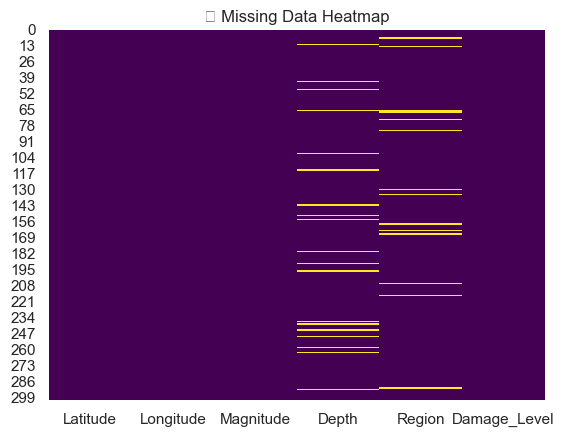

In [30]:
print("🔍 Missing Values Count:")
print(df.isnull().sum())

# Plot missing values
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("🟡 Missing Data Heatmap")
plt.show()

In [31]:
# Fill numeric (Depth) with median
df["Depth"].fillna(df["Depth"].median(), inplace=True)

# Fill categorical (Region) with mode
df["Region"].fillna(df["Region"].mode()[0], inplace=True)

print("✅ Missing values handled!")
print(df.isnull().sum())

✅ Missing values handled!
Latitude        0
Longitude       0
Magnitude       0
Depth           0
Region          0
Damage_Level    0
dtype: int64


/var/folders/3p/rbmdhw9j4qb0vm6n1d_1n8kr0000gn/T/ipykernel_3642/958508461.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Depth"].fillna(df["Depth"].median(), inplace=True)
/var/folders/3p/rbmdhw9j4qb0vm6n1d_1n8kr0000gn/T/ipykernel_3642/958508461.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [32]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Region"] = le.fit_transform(df["Region"])
df["Damage_Level"] = le.fit_transform(df["Damage_Level"])

print("✅ Encoding Done!")
df.head()

✅ Encoding Done!


,Latitude,Longitude,Magnitude,Depth,Region,Damage_Level
0,-22.582779,-161.394580,3.844675,146.312492,2,0
1,81.128575,11.287667,4.392952,19.546011,1,2
2,41.758910,14.628644,3.885052,127.823369,0,1
3,17.758527,49.474765,3.443513,408.546051,2,2
4,-61.916645,81.392880,3.603179,295.575761,0,1


In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[["Latitude", "Longitude", "Magnitude", "Depth"]])

scaled_df = pd.DataFrame(scaled_features, columns=["Latitude", "Longitude", "Magnitude", "Depth"])
scaled_df["Region"] = df["Region"]
scaled_df["Damage_Level"] = df["Damage_Level"]

print("✅ Features Scaled!")
scaled_df.head()

✅ Features Scaled!


,Latitude,Longitude,Magnitude,Depth,Region,Damage_Level
0,-0.410634,-1.519933,-1.067852,-1.089638,2,0
1,1.550146,0.067938,-0.680316,-1.723266,1,2
2,0.805818,0.098660,-1.039313,-1.182054,0,1
3,0.352064,0.419081,-1.351405,0.221107,2,2
4,-1.154284,0.712579,-1.238548,-0.343562,0,1


/Users/badrirohith/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


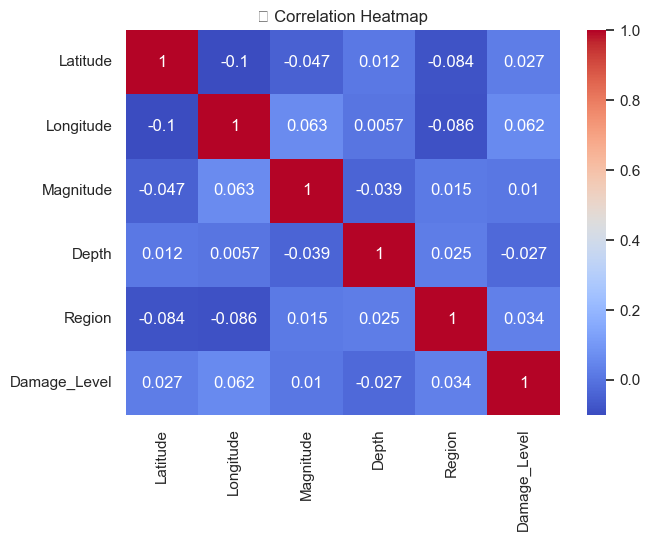

In [34]:
plt.figure(figsize=(7,5))
sns.heatmap(scaled_df.corr(), annot=True, cmap="coolwarm")
plt.title("📊 Correlation Heatmap")
plt.show()

In [35]:
import pandas as pd
import numpy as np

np.random.seed(42)
n = 500
df = pd.DataFrame({
    "Latitude": np.random.uniform(-90, 90, n),
    "Longitude": np.random.uniform(-180, 180, n),
    "Magnitude": np.random.uniform(3, 9, n),
    "Depth": np.random.uniform(1, 700, n),
    "Damage_Level": np.random.choice(["Low", "Medium", "High"], n, p=[0.5, 0.3, 0.2])
})

df.head()

,Latitude,Longitude,Magnitude,Depth,Damage_Level
0,-22.582779,71.338217,4.110798,363.838168,Low
1,81.128575,12.994692,6.251406,335.948132,Low
2,41.758910,-68.570058,8.237675,18.923804,High
3,17.758527,112.966207,7.393349,239.532232,Low
4,-61.916645,66.503222,7.839367,266.756738,Low


In [36]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

le = LabelEncoder()
df["Damage_Level_encoded"] = le.fit_transform(df["Damage_Level"])
print("Encoded classes:", dict(zip(le.classes_, le.transform(le.classes_))))

X = df[["Latitude", "Longitude", "Magnitude", "Depth"]]
y = df["Damage_Level_encoded"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

Encoded classes: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


array([[-0.41563649,  0.75807991, -1.11967036,  0.07884027],
       [ 1.51530965,  0.18984392,  0.0819912 , -0.06031825],
       [ 0.78230693, -0.60455487,  1.19701243, -1.64212467],
       [ 0.33545667,  1.16351517,  0.7230379 , -0.5413895 ],
       [-1.14797267,  0.71098954,  0.97341636, -0.40555167]])

In [37]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("X_train_res shape:", X_train_res.shape)
print("y_train_res shape:", y_train_res.shape)

X_train_res shape: (603, 4)
y_train_res shape: (603,)


/Users/badrirohith/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Accuracy: 0.42
              precision    recall  f1-score   support

        High       0.17      0.20      0.19        20
         Low       0.58      0.50      0.54        50
      Medium       0.38      0.43      0.41        30

    accuracy                           0.42       100
   macro avg       0.38      0.38      0.38       100
weighted avg       0.44      0.42      0.43       100



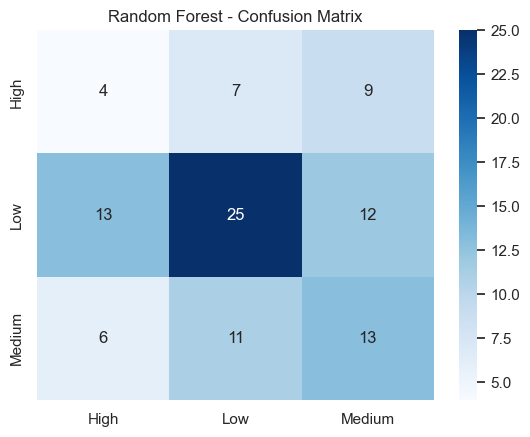

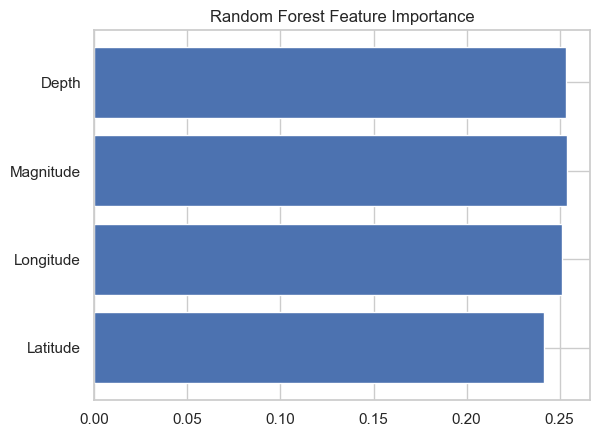

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)
rf_preds = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds, target_names=le.classes_))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_preds)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest - Confusion Matrix")
plt.show()

# Feature Importance
importances = rf_model.feature_importances_
plt.barh(X.columns, importances)
plt.title("Random Forest Feature Importance")
plt.show()

/Users/badrirohith/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.33
              precision    recall  f1-score   support

        High       0.15      0.20      0.17        20
         Low       0.48      0.44      0.46        50
      Medium       0.25      0.23      0.24        30

    accuracy                           0.33       100
   macro avg       0.29      0.29      0.29       100
weighted avg       0.34      0.33      0.34       100



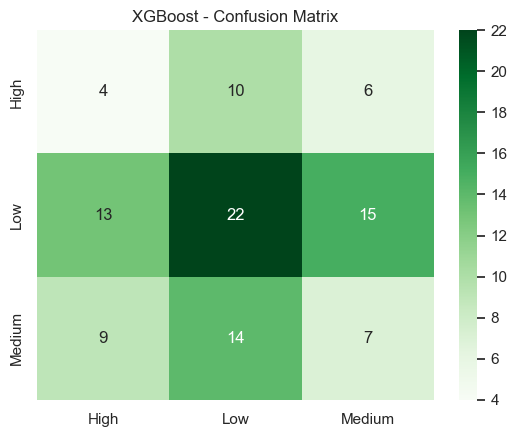

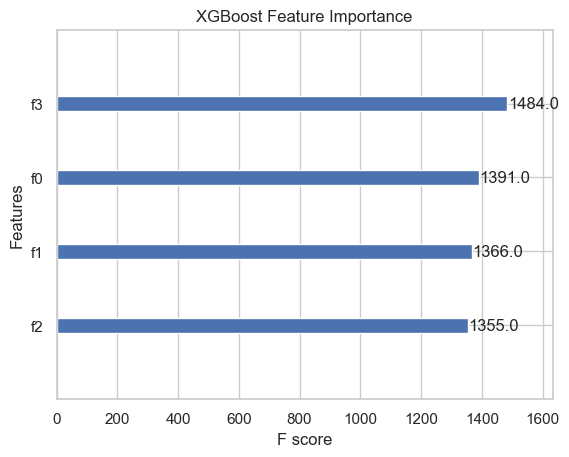

In [39]:
from xgboost import XGBClassifier, plot_importance

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_model.fit(X_train_res, y_train_res)
xgb_preds = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds, target_names=le.classes_))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_preds)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost - Confusion Matrix")
plt.show()

# Feature Importance
plot_importance(xgb_model)
plt.title("XGBoost Feature Importance")
plt.show()